# Visualization
In this notebook, we're going to explore what the model we have trained actually learned.
This involves some of the following things:
* **Verify that we actually get better while learning**
* **Look at the motifs we learn**
* What does the hidden layer tell us about the model

In [1]:
# some always important inputs
import sys
import os
import random
import time
import numpy as np
import cPickle
#import PIL

# the underlying convRBM implementation
sys.path.append(os.path.abspath('../code'))
from convRBM import CRBM
import getData as dataRead

# plotting and data handling
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split

# the biopython stuff
import Bio.SeqIO as sio
import Bio.motifs.matrix as mat
from Bio.Alphabet import IUPAC
from Bio.Seq import Seq
from Bio import motifs as mot

ERROR (theano.sandbox.cuda): Failed to compile cuda_ndarray.cu: libcublas.so.7.0: cannot open shared object file: No such file or directory
ERROR:theano.sandbox.cuda:Failed to compile cuda_ndarray.cu: libcublas.so.7.0: cannot open shared object file: No such file or directory
WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu is not available  (error: cuda unavilable)


Couldn't import dot_parser, loading of dot files will not be possible.


## Read in the data and a previously trained model
This part of the notebook trains a convolutional RBM on the DHS data. This may take a lot of time but only once we trained it, will it be possible to do the visualization of what the model learnt.

In [37]:
# read in the model
date_string = '2016_02_02_13_46'
modelDir = '../../training/' + date_string
learner = CRBM(file_name = modelDir + '/model.pkl')

In [38]:
print learner.motifs.get_value()[0]

[[[ 0.2195188   0.07522294  0.21745369  0.86289918  0.62525558  0.54436618
    0.38655663  0.27425042  0.1367991 ]
  [ 0.32652849  0.56804013  0.94556773  1.0603267   0.44618961  0.29789251
    0.41251361  0.20500338  0.15694208]
  [ 0.03174714  0.04695427 -0.29767075  0.33012646  0.56325692  0.53635162
    0.95309436  0.8122623   0.51314503]
  [ 0.73051363  1.00459909  0.48766869  0.58202058  0.71886295  0.12648007
    0.59683681  0.49612004  0.25585142]]]


### Some basic funcions to get motifs from the matrices

In [39]:
def getLetterToInt (num):
    if num == 0:
        return 'A'
    elif num == 1:
        return 'C'
    elif num == 2:
        return 'G'
    elif num == 3:
        return 'T'
    else:
        print 'ERROR: Num ' + str(num) + " not a valid char in DNA alphabet"
        return -1

def createMotifFromMatrix (matrix, alphabet=IUPAC.unambiguous_dna):
    assert matrix.shape[0] == 4
    
    # transform the matrix such that the log odds are taken away
    # matrix_ij = log(foreground/background) <=> log(foreground) - log(background)
    psm = matrix + np.log(0.25) # 0.25 if we treat all letters as equally probable
    psm = np.exp(psm)
    psm = psm / psm.sum(axis=1, keepdims=True)
    
    # make this matrix a valid motif
    counts = {}
    for row in range(4):
        counts[getLetterToInt(row)] = (psm[row]).tolist()
    motif = mot.Motif(alphabet=alphabet, instances=None, counts=counts)
    return motif


def weblogo(motif, file_format="png", version="2.8.2", **kwds): 
    from Bio._py3k import urlopen, urlencode, Request 
    frequencies = motif.format('transfac') 
    url = 'http://weblogo.threeplusone.com/create.cgi' 
    values = {'sequences': frequencies, 
                    'format': file_format.lower(), 
                    'stack_width': 'medium', 
                    'stack_per_line': '40', 
                    'alphabet': 'alphabet_dna', 
                    'ignore_lower_case': True, 
                    'unit_name': "bits", 
                    'first_index': '1', 
                    'logo_start': '1', 
                    'logo_end': str(motif.length), 
                    'composition': "comp_auto", 
                    'percentCG': '', 
                    'scale_width': True, 
                    'show_errorbars': False, 
                    'logo_title': '', 
                    'logo_label': '', 
                    'show_xaxis': False, 
                    'xaxis_label': '', 
                    'show_yaxis': False, 
                    'yaxis_label': '', 
                    'yaxis_scale': 'auto', 
                    'yaxis_tic_interval': '1.0', 
                    'show_ends': False, 
                    'show_fineprint': False, 
                    'color_scheme': 'color_auto', 
                    'symbols0': '', 
                    'symbols1': '', 
                    'symbols2': '', 
                    'symbols3': '', 
                    'symbols4': '', 
                    'color0': '', 
                    'color1': '', 
                    'color2': '', 
                    'color3': '', 
                    'color4': '', 
                    } 
    values.update(dict((k, "" if v is False else str(v)) for k, v in kwds.items()))
    data = urlencode(values).encode("utf-8")
    req = Request(url, data)
    response = urlopen(req)
    return response


def getLogoListFrom4DMatrix(matrix):
    images = []
    for motifNum in range(matrix.shape[0]):
        m = createMotifFromMatrix(matrix[motifNum,0])
        reader = weblogo(m)
        images.append(plt.imread(reader))
    return images

import math
bestSplit = lambda x: (round(math.sqrt(x)), math.ceil(x / round(math.sqrt(x))))

def getObserverIndex(string):
    count = 0
    for obs in learner.observers:
        if string in obs.name.lower():
            print "Chose observer: " + obs.name
            return count
        count += 1

def plotMotifHitsForFrame (frameNr):
    obsIdx = getObserverIndex("hit")
    scores = learner.observers[obsIdx].scores[frameNr].sum(axis=0)
    scores = scores.reshape(-1)
    plt.bar(range(0,scores.shape[0]), scores)
    plt.show()

In [40]:
learner.printHyperParams()
print len(learner.observers[getObserverIndex("motif")].scores)

{'learning_rate': 0.0001,
 'motif_length': 9,
 'number_of_motifs': 20,
 'pooling_factor': 2}
Chose observer: Motif Hit Observer
201


## Make a video from the motifs in which we have a subplot of all motifs per frame!
For that, we have to find out how we can simply get the image without writing it to disk first.
Then, we can use python multimedia capabilities for some nice plotting!

In [6]:
# get the logos for all scores during training
observerIndex = getObserverIndex()
logosOverTime = []
numberOfEpochs = 200
frames = min(len(learner.observers[observerIndex].scores), numberOfEpochs)
for timeSlice in range(frames):
    allMotifsPerSlice = learner.observers[observerIndex].scores[timeSlice]
    logosOverTime.append(getLogoListFrom4DMatrix(allMotifsPerSlice))
    print "Got Logos for Time/Epoch " + str(timeSlice)

Got Logos for Time/Epoch 0
Got Logos for Time/Epoch 1
Got Logos for Time/Epoch 2
Got Logos for Time/Epoch 3
Got Logos for Time/Epoch 4
Got Logos for Time/Epoch 5
Got Logos for Time/Epoch 6
Got Logos for Time/Epoch 7
Got Logos for Time/Epoch 8
Got Logos for Time/Epoch 9
Got Logos for Time/Epoch 10
Got Logos for Time/Epoch 11
Got Logos for Time/Epoch 12
Got Logos for Time/Epoch 13
Got Logos for Time/Epoch 14
Got Logos for Time/Epoch 15
Got Logos for Time/Epoch 16
Got Logos for Time/Epoch 17
Got Logos for Time/Epoch 18
Got Logos for Time/Epoch 19
Got Logos for Time/Epoch 20
Got Logos for Time/Epoch 21
Got Logos for Time/Epoch 22
Got Logos for Time/Epoch 23
Got Logos for Time/Epoch 24
Got Logos for Time/Epoch 25
Got Logos for Time/Epoch 26
Got Logos for Time/Epoch 27
Got Logos for Time/Epoch 28
Got Logos for Time/Epoch 29
Got Logos for Time/Epoch 30
Got Logos for Time/Epoch 31
Got Logos for Time/Epoch 32
Got Logos for Time/Epoch 33
Got Logos for Time/Epoch 34
Got Logos for Time/Epoch 35
Go

(30, 1, 4, 11)
5.0 6.0
in init
30


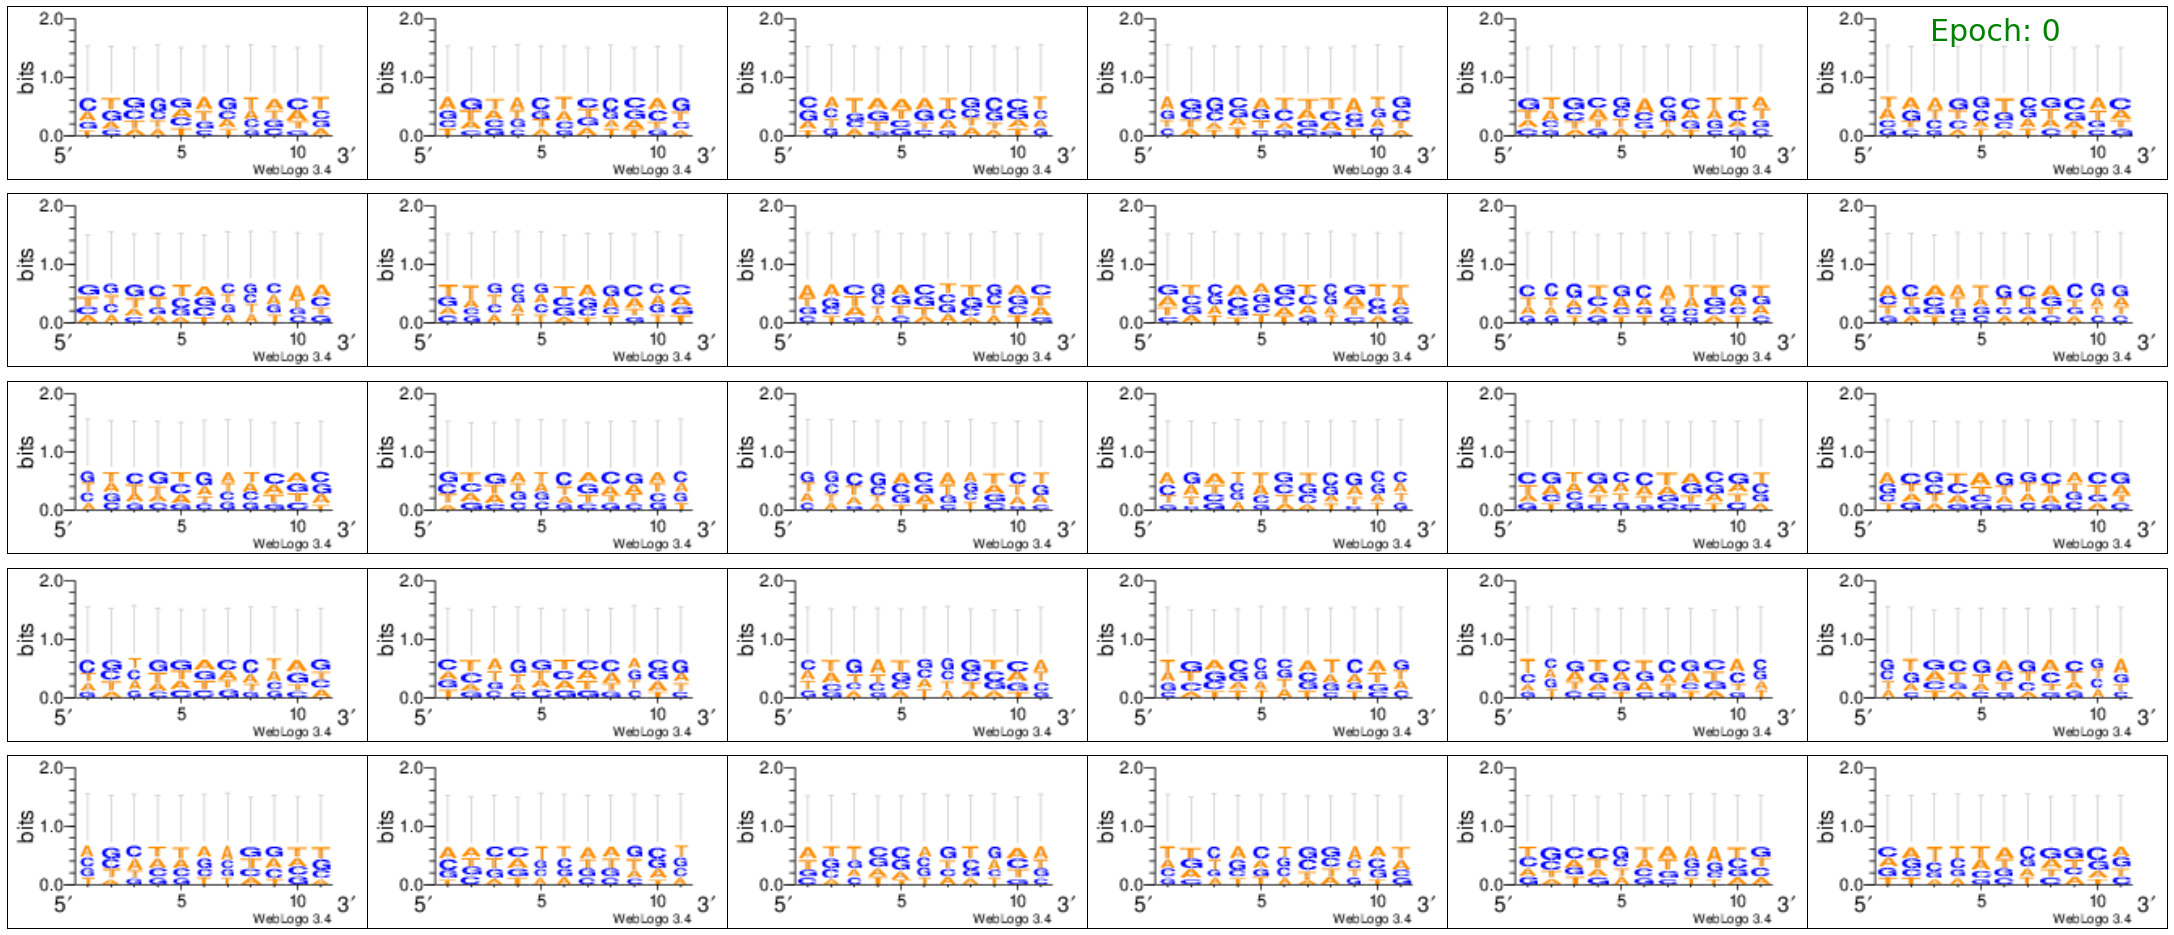

In [62]:
from matplotlib import animation

fig = plt.figure(figsize=(30,13))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0)
frame_text = fig.text(0.95, 0.95,
                      'Epoch: ' + str(0),
                      verticalalignment='bottom',
                      horizontalalignment='right',
                      color='green', fontsize=30)
allMotifsOverTime = learner.observers[observerIndex].scores
print allMotifsOverTime[0].shape

x, y = bestSplit(allMotifsOverTime[0].shape[0])
print x, y
axesList = []

def init():
    print "in init"
    for i in range(allMotifsOverTime[0].shape[0]):
        ax = fig.add_subplot(x, y, i+1, xticks=[], yticks=[])
        im = ax.imshow(logosOverTime[0][i])
        axesList.append(im)
    print len(axesList)
        
def printFrame(frameNr):
    numMotifs = allMotifsOverTime[frameNr].shape[0]
    for motif in range(numMotifs):
        axesList[motif].set_data(logosOverTime[frameNr][motif])
        #ax.imshow(logosOverTime[frameNr][motif])
    frame_text.set_text('Epoch: ' + str(frameNr))

anim = animation.FuncAnimation(fig,
                               printFrame,
                               init_func=init,
                               frames=frames,
                               interval=200, repeat=True)
#anim.save(modelDir + '/motifChanges.mp4', fps=10)
plt.show()

## Visualize motif hits

Chose observer: Motif Hit Observer


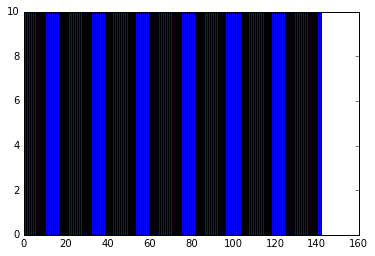

Chose observer: Motif Hit Observer


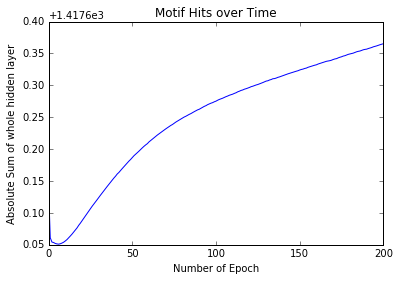

In [42]:
%matplotlib inline
    
plotMotifHitsForFrame(199)

idx = getObserverIndex("hit")
l = []
for i in range(len(learner.observers[idx].scores)):
    l.append(np.abs(learner.observers[idx].scores[i]).sum())

plt.title('Motif Hits over Time')
plt.ylabel('Absolute Sum of whole hidden layer')
plt.xlabel('Number of Epoch')
plt.plot(l)
plt.savefig(modelDir + '/motifHitsOverTime.png', dpi=400)

## Plot the development of the weights over time

Chose observer: Parameter Observer


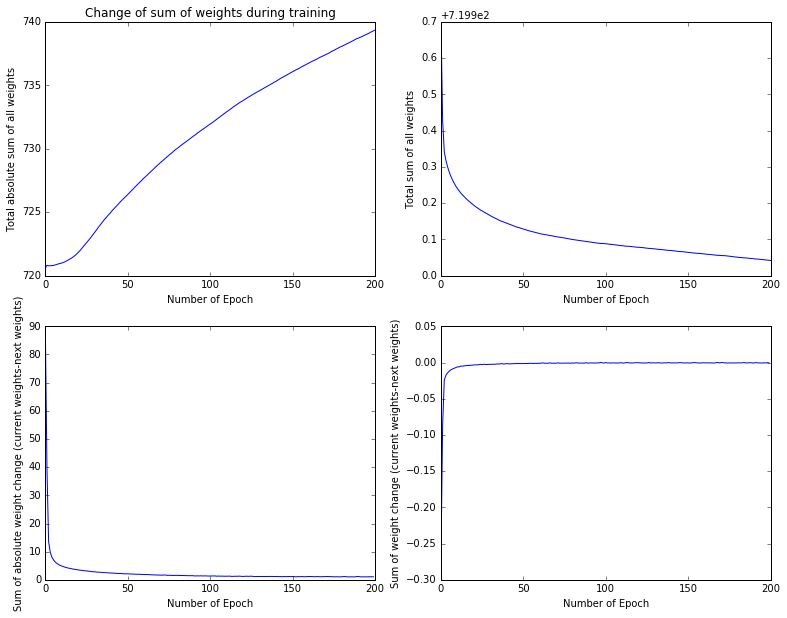

In [58]:
%matplotlib inline

listOfAbsSums = []
listOfSums = []

idx = getObserverIndex("parameter")
obsRef = learner.observers[idx]
for i in range(len(obsRef.scores)):
    listOfAbsSums.append(np.abs(obsRef.scores[i][0]).sum())

for i in range(len(learner.observers[idx].scores)):
    listOfSums.append(learner.observers[idx].scores[i][0].sum())
    
fig = plt.figure(figsize=(13,10))

ax1 = fig.add_subplot(2,2,1)
ax1.set_xlabel('Number of Epoch')
ax1.set_title('Change of sum of weights during training')
ax1.set_ylabel('Total absolute sum of all weights')
ax1.plot(listOfAbsSums)
#ax1.savefig(modelDir + '/weightDevelopmentAbs.png', dpi=600)

ax2 = fig.add_subplot(2,2,2)
ax2.set_xlabel('Number of Epoch')
ax2.set_ylabel('Total sum of all weights')
ax2.plot(listOfSums)

listOfDiffs = []
for i in range(len(obsRef.scores)-1):
    listOfDiffs.append((obsRef.scores[i+1][0]-obsRef.scores[i][0]).sum())

listOfDiffsAbs = []
for i in range(len(learner.observers[idx].scores)-1):
    listOfDiffsAbs.append(np.abs(obsRef.scores[i+1][0]-obsRef.scores[i][0]).sum())

ax3 = fig.add_subplot(2,2,3)
ax3.set_xlabel('Number of Epoch')
ax3.set_ylabel('Sum of absolute weight change (current weights-next weights)')
ax3.plot(listOfDiffsAbs)

ax4 = fig.add_subplot(2,2,4)
ax4.set_xlabel('Number of Epoch')
ax4.set_ylabel('Sum of weight change (current weights-next weights)')
ax4.plot(listOfDiffs)

fig.savefig(modelDir + '/weightDevelopment.png', dpi=600)

## Plot the other parameters (bias and c)

Chose observer: Parameter Observer


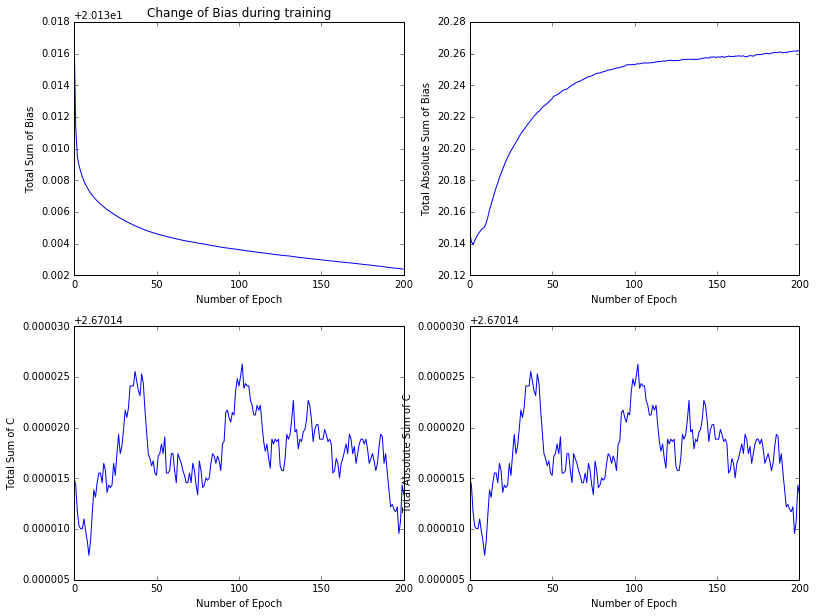

In [57]:
%matplotlib inline

listOfBiasSum = []
listOfBiasSumAbs = []
listOfCSum = []
listOfCSumAbs = []

idx = getObserverIndex("parameter")
obsRef = learner.observers[idx]
for i in range(len(obsRef.scores)):
    listOfBiasSum.append(obsRef.scores[i][1].sum())
    listOfBiasSumAbs.append(np.abs(obsRef.scores[i][1]).sum())
    listOfCSum.append(obsRef.scores[i][2].sum())
    listOfCSumAbs.append(np.abs(obsRef.scores[i][2]).sum())

fig = plt.figure(figsize=(13,10))

ax1 = fig.add_subplot(2,2,1)
ax1.set_xlabel('Number of Epoch')
ax1.set_title('Change of Bias during training')
ax1.set_ylabel('Total Sum of Bias')
ax1.plot(listOfBiasSum)

ax2 = fig.add_subplot(2,2,2)
ax2.set_xlabel('Number of Epoch')
ax2.set_ylabel('Total Absolute Sum of Bias')
ax2.plot(listOfBiasSumAbs)

ax3 = fig.add_subplot(2,2,3)
ax3.set_xlabel('Number of Epoch')
ax3.set_ylabel('Total Sum of C')
ax3.plot(listOfCSum)

ax4 = fig.add_subplot(2,2,4)
ax4.set_xlabel('Number of Epoch')
ax4.set_ylabel('Total Absolute Sum of C')
ax4.plot(listOfCSumAbs)

fig.savefig(modelDir + '/biasDevelopment.png', dpi=600)

(201, 1, 4)
(201, 4)


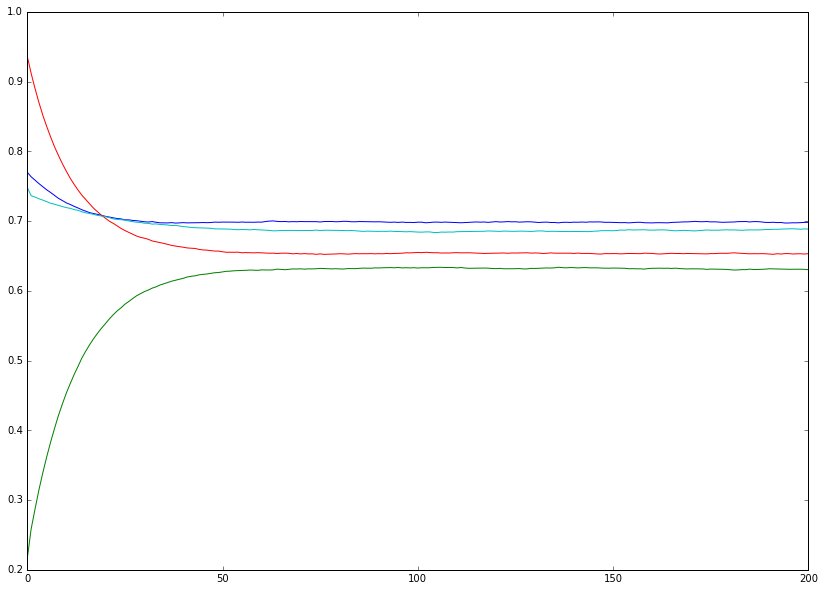

In [47]:
fig = plt.figure(figsize=(14,10))
cs = np.array([i[2] for i in obsRef.scores])
cs = cs.reshape(cs.shape[0],4)
for i in range(4):
    plt.plot(cs[:,i])

(201, 1, 40)


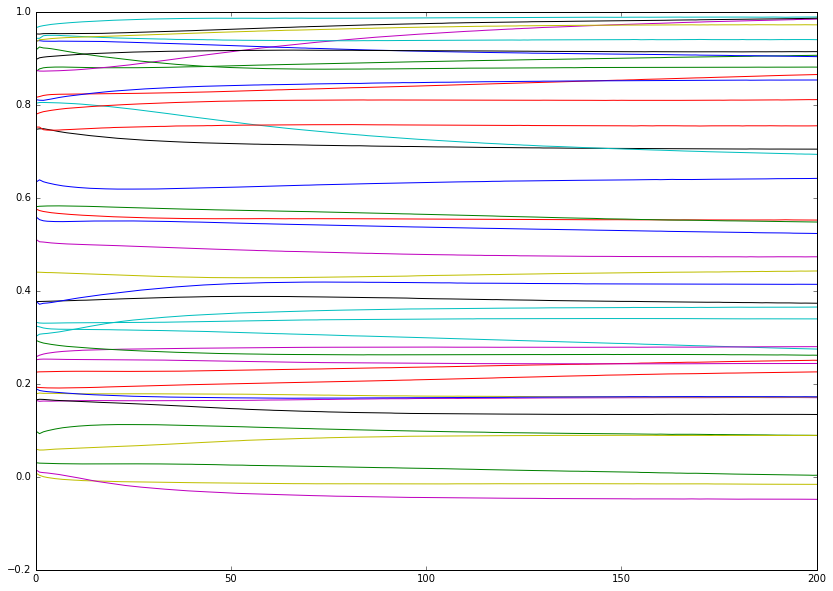

In [50]:
fig = plt.figure(figsize=(14,10))
bs = np.array([i[1] for i in obsRef.scores])
print bs.shape
bs = bs.reshape(bs.shape[0],bs.shape[2])
for i in range(bs.shape[1]):
    plt.plot(bs[:,i])

## Plot the gradients as heat maps
This may aide in finding out what's going wrong during the learning.

Chose observer: Parameter Observer
201


<IPython.core.display.Javascript object>


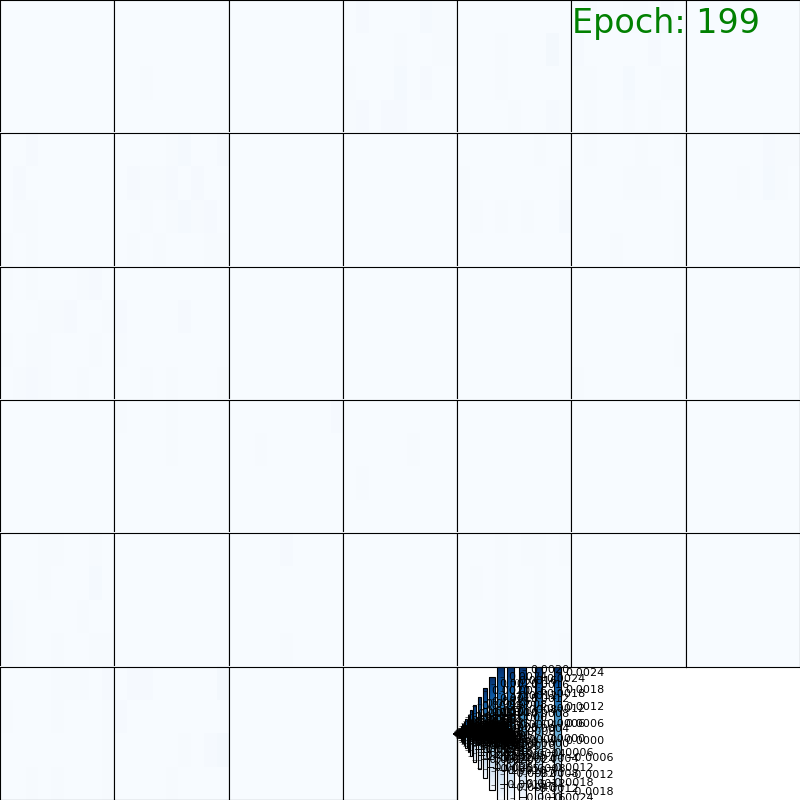

In [66]:
%matplotlib nbagg

import pprint
from matplotlib import animation

def getHeatmapFrom2DMat(matrix):
    plt.pcolor(matrix[::-1,:], cmap=plt.cm.Blues)
    plt.colorbar()
    print pprint.pprint(matrix)

observerIdx = getObserverIndex("parameter")
obsRef = learner.observers[observerIdx]
numberOfEpochs = 900
frames = min(len(obsRef.scores), numberOfEpochs)
print frames

fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0)
x, y = bestSplit(obsRef.scores[0][0].shape[0])
frame_text = fig.text(0.95, 0.95,
                      'Epoch: ' + str(0),
                      verticalalignment='bottom',
                      horizontalalignment='right',
                      color='green', fontsize=30)

axesList = []
def initHeatmaps():
    allDiffsZero = np.abs(obsRef.scores[1][0] - obsRef.scores[0][0])
    for i in range(allDiffsZero.shape[0]):
        ax = fig.add_subplot(x, y, i+1, xticks=[], yticks=[])
        im = ax.pcolorfast(allDiffsZero[i,0,::-1,:],cmap=plt.cm.Blues)
        axesList.append(im)
    print "end of init with " + str(len(axesList))

def plotGradientForFrame(frameNr):
    assert frameNr < len(obsRef.scores)-1
    allDiffsPerEpoch = np.abs(obsRef.scores[frameNr+1][0] - obsRef.scores[frameNr][0])
    for motif in range(allDiffsPerEpoch.shape[0]):
        axesList[motif].set_data(allDiffsPerEpoch[motif,0,::-1,:])
    frame_text.set_text('Epoch: ' + str(frameNr))


anim = animation.FuncAnimation(fig,
                               plotGradientForFrame,
                               init_func=initHeatmaps,
                               frames=frames,
                               interval=20, repeat=False)
#anim.save(modelDir + '/derivativeChanges.mp4', fps=10)

## Plot the motifs for one specific epoch
This is similar to the motif generation but only for one frame instead of a whole video.

Chose observer: Parameter Observer


<IPython.core.display.Javascript object>


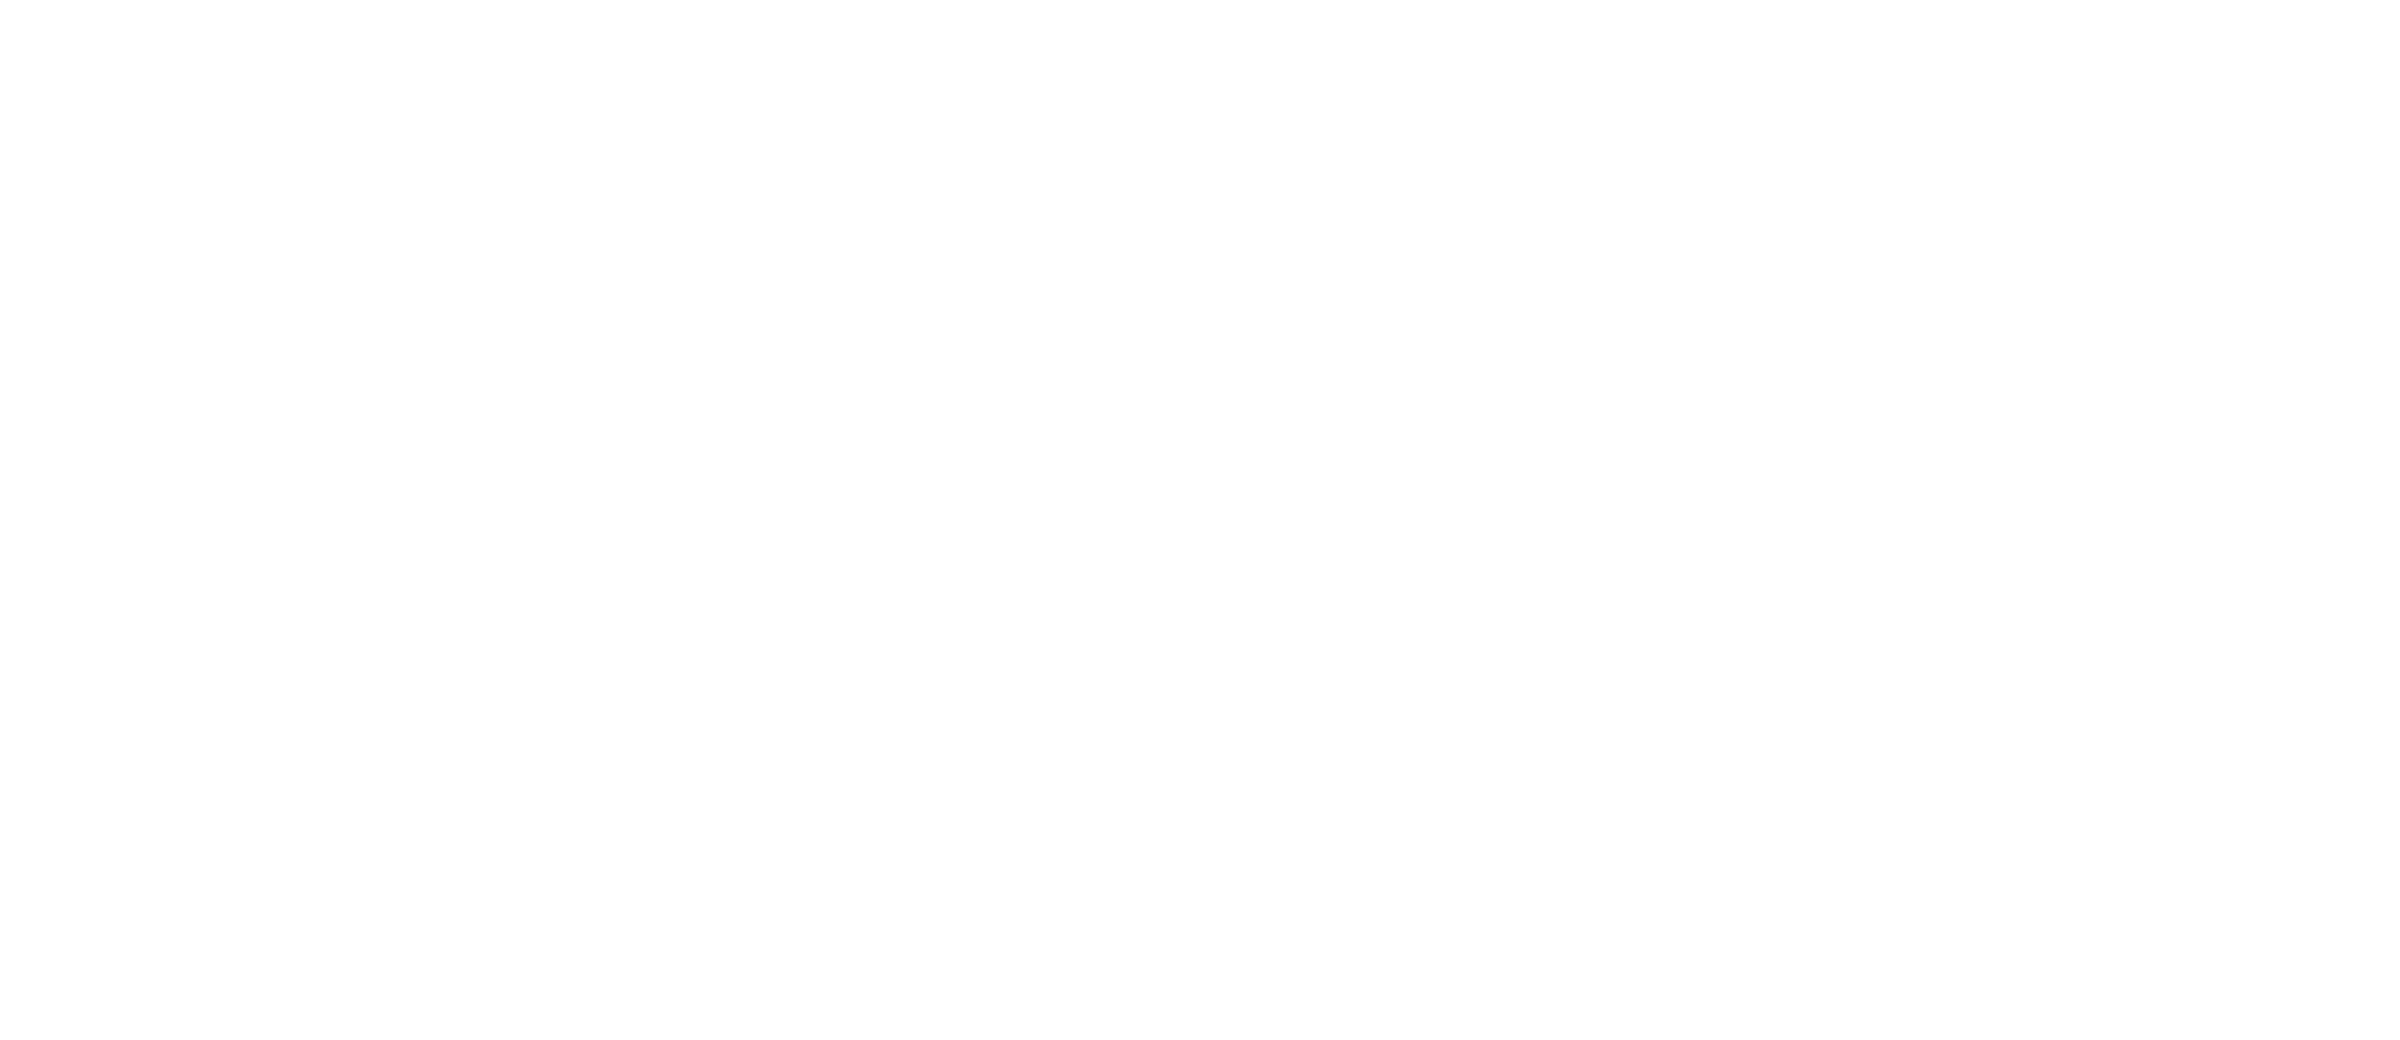

6.0 7.0


URLError: <urlopen error [Errno 110] Connection timed out>

In [64]:
# TEMP
observerIndex = getObserverIndex("parameter")
fig = plt.figure(figsize=(30,13))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0)
x, y = bestSplit(learner.observers[observerIndex].scores[0][0].shape[0])
print x, y

def showFrame(frameNr):
    allMotifsForFrame = learner.observers[observerIndex].scores[frameNr][0]
    logos = getLogoListFrom4DMatrix(allMotifsForFrame)
    for motif in range(allMotifsForFrame.shape[0]):
        ax = fig.add_subplot(x, y, motif+1, xticks=[], yticks=[])
        ax.imshow(logos[motif])
    plt.savefig(modelDir + '/learnedMotif' + str(frameNr) + '.png')
showFrame(199)#len(learner.observers[observerIndex].scores)-1)

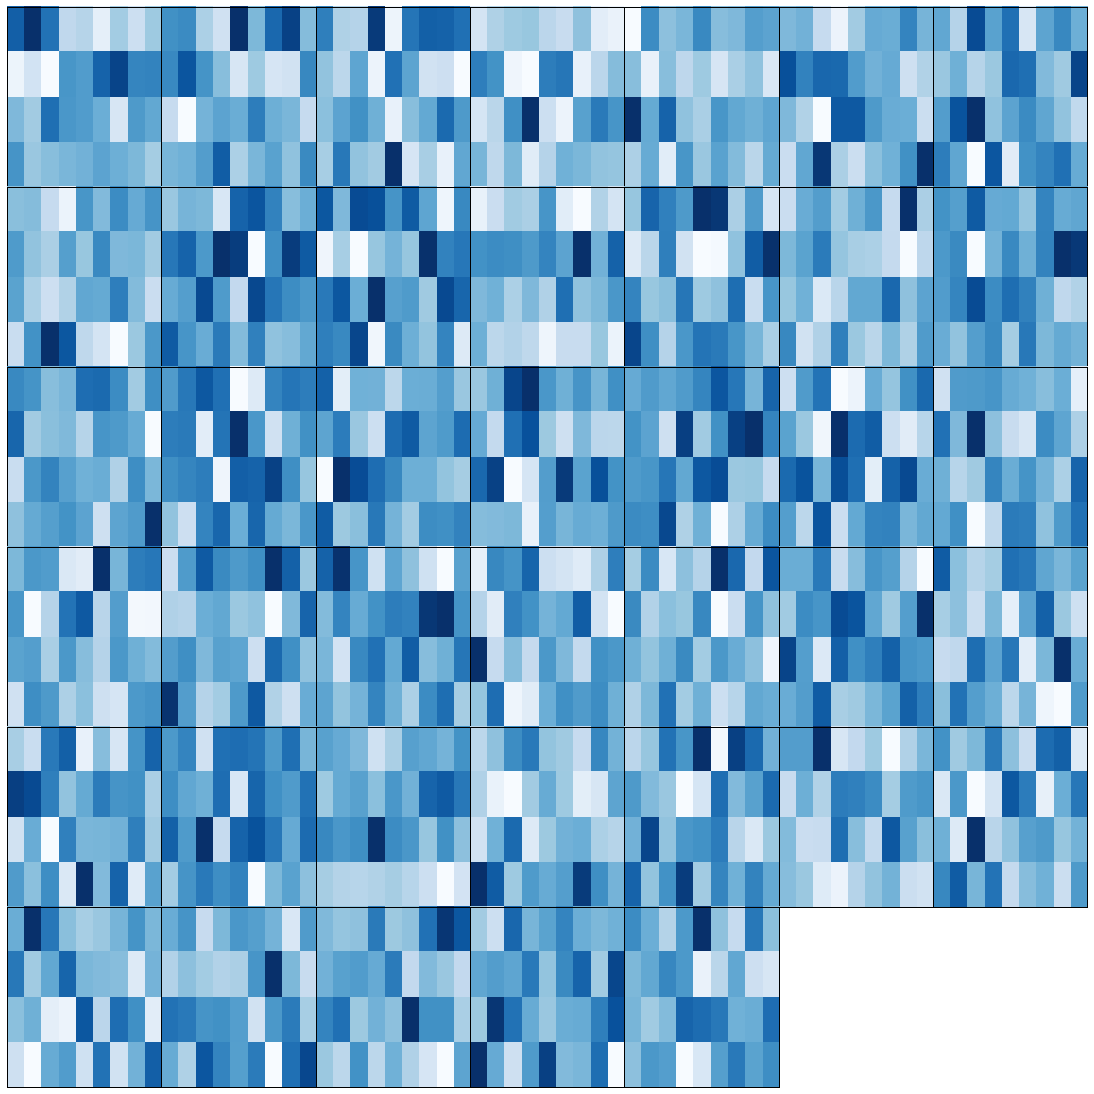

In [84]:
%matplotlib inline
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0)
#x, y = bestSplit(obsRef.scores[0][0].shape[0])

def plotGradientForFrame(frameNr):
    assert frameNr < len(learner.observers[observerIdx].scores)-1
    allDiffsPerEpoch = learner.observers[observerIdx].scores[frameNr+1][0] - learner.observers[observerIdx].scores[frameNr][0]
    for motif in range(allDiffsPerEpoch.shape[0]):
        ax = fig.add_subplot(x,y,motif+1, xticks=[], yticks=[])
        ax.pcolorfast(allDiffsPerEpoch[motif,0], cmap=plt.cm.Blues)
    #plt.colorbar()
    
plotGradientForFrame(60)
plt.show()

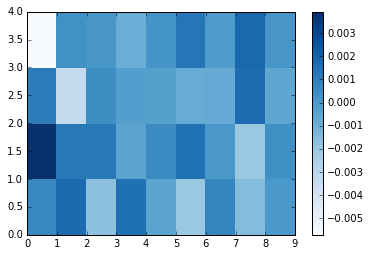

In [74]:
%matplotlib inline
frameNr = 100
allDiffsPerEpoch = learner.observers[observerIdx].scores[frameNr+1][0] - learner.observers[observerIdx].scores[frameNr][0]
plt.pcolor(allDiffsPerEpoch[4,0], cmap=plt.cm.Blues)
plt.colorbar()
plt.show()